In [6]:
# Package Imports

import sklearn as sk
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from  matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.dummy import DummyRegressor

1. Cite your source of data...

The data used in this project comes from an SQLite database that was compiled in Dr. Harrison's research lab. The data is playing_time data for

In [7]:
# Import dataset
df = pl.read_csv("project1_2008_all.csv")

# Read more csv's and concatenate (Optional)
# df2 = pl.read_csv("project1_2009_all.csv")
# df = pl.concat([df, df2])

# Add goal_differential column to the dataframe
df = df.with_columns(
    (pl.col("goals_scored") - pl.col("goals_allowed")).alias("goal_differential")
)

# Convert 'col1' from float64 to int16 Future opitmization
# df = df.with_columns([
#     pl.col('goals_scored').cast(pl.Int16),  # Cast column from float64 to int16
# ])

df

match_id,team_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,goals_scored,goals_allowed,goal_differential
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
220071,362,48,34,16,25,29,16,13,44,51,50,60,20,105,35,22,16,72,68,221,19,45,29,19,15,34,43,54,16,23,23,14,18,20,20,24,15,12,42,37,96,23,16,32,39,35,15,18,20,20,15,16,16,61,66,65,2.0,1.0,1.0
220071,367,110,101,39,48,79,63,52,78,18,11,186,62,71,112,88,70,120,21,14,64,72,116,89,70,100,22,14,65,59,55,61,53,23,15,69,57,67,62,23,14,81,70,91,17,10,55,75,19,15,56,21,12,19,14,13,1.0,2.0,-1.0
220074,370,14,16,39,31,14,16,30,54,13,17,48,8,19,11,18,19,19,8,18,2,17,14,15,17,16,8,16,20,2,8,20,110,12,7,15,21,37,36,12,22,39,15,14,8,15,21,20,9,20,43,13,22,17,21,11,1.0,2.0,-1.0
220074,363,14,10,20,17,3,14,20,8,19,18,55,85,90,38,15,23,39,62,18,124,53,34,8,11,33,48,9,76,18,16,26,23,39,20,45,14,23,43,61,19,3,5,33,38,4,18,8,17,12,11,26,22,36,9,21,2.0,1.0,1.0
220070,359,36,46,38,44,20,33,37,11,41,25,56,47,56,32,31,44,11,50,39,75,161,72,91,102,16,162,133,76,32,57,56,12,71,59,74,106,132,15,163,123,30,54,7,70,50,55,10,86,74,15,98,75,11,13,125,2.0,0.0,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
259145,248,21,18,20,21,21,21,20,19,20,20,19,21,22,22,22,21,20,21,21,18,19,19,19,18,17,25,18,21,31,21,20,38,30,20,22,22,109,20,21,21,22,21,27,31,21,21,20,21,21,19,20,20,27,19,20,1.0,0.0,1.0
253277,5325,14,4,14,9,15,10,15,15,15,13,4,14,10,15,11,15,15,15,13,28,6,24,39,36,17,14,18,17,37,57,56,36,34,41,14,17,16,13,11,14,42,45,23,26,26,68,29,30,36,30,34,37,26,34,28,1.0,0.0,1.0
253277,5322,4,6,5,6,6,5,5,6,6,2,64,50,28,27,34,20,25,14,1,52,26,25,31,19,25,14,2,21,21,24,16,20,13,2,29,30,19,24,16,2,32,19,24,14,2,21,27,15,2,22,11,2,13,2,2,0.0,1.0,-1.0


In [8]:
# Set random state
random_state = 42

# Filter out rows where 'goal_differential' is NaN or null
original_rows = df.shape[0]
df = df.filter(
    pl.col("goal_differential").is_not_null()
    & pl.col("goal_differential").is_finite()
)
rows_removed = original_rows - df.shape[0]
print(f"Rows removed from df after filtering: {rows_removed}")

# Filter the dataframe to only take certain rows based on team id (Optional)


Rows removed from df after filtering: 4


2. Set aside 10% of your datapoints as a Test set. This will be used to compare the final performance of
 all the models we train.

 When splitting the data into test and training sets, We need to ensure that the random shuffling is stratefied by matches. This ensures that there is no data leakage, since the teams affect the outcome of the match.

In [9]:
# Stratify the shuffling based on match_id
#   (This ensures we have no data leakage)
match_ids = df['match_id'].unique()

gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=random_state)

train_holdout_idx, test_idx = next(gss.split(df, groups=df['match_id']))

train_holdout_df = df[train_holdout_idx]
test_df = df[test_idx]

print(f"Train/Holdout shape: {train_holdout_df.shape} ~{train_holdout_df.shape[0]/df.shape[0]}%") # 90%
print(f"Test shape: {test_df.shape} ~{test_df.shape[0]/df.shape[0]}%") # 10%

# Grab feature rows
X_columns = [f"feature_{i+1}" for i in range(55)]
y_column = ["goal_differential"]


# Set aside final test dataset
X_test, y_test = test_df[X_columns], test_df[y_column] # This is the final test dataset

X_train_holdout, y_train_holdout = train_holdout_df[X_columns], train_holdout_df[y_column]

Train/Holdout shape: (24312, 60) ~0.89997778929444%
Test shape: (2702, 60) ~0.10002221070556008%


 3. Choose the form of your error function based on whether you are solving a regression or classification
 problem:

 • We will use a Regression model! This is because the output we are using is goal differential

 Note: Use the mean squared error for your error function. In scikit-learn, this corresponds to setting the keyword argument scoring=’neg_mean_squared_error', when using sklearn.model_selection.cross_val_score
 (We will make sure to take the negative of the returned value to get the correct positive value)

 I decided not to use a standard scaler because I predict that exceptionally high playing time values will be a strong indicator of team success (so I am fine if those values skew the dataset sometimes)

4. Select a method to estimate the value of your error function on new data (E_new). Clearly state in your
 writeup which method you chose. You’ll need to use the same method for all of the models you train.

 • We will choose to estimate E_new using Holdout cross validation (Option 2).
 We are going to use a 20% of the entire dataset as our validation set, with the rest being test data. Our final percentages being: 70% train / 20% validate / 10% test.

In [10]:
gss2 = GroupShuffleSplit(n_splits=1, test_size=20/90, random_state=random_state)
train_idx, holdout_idx = next(gss2.split(train_holdout_df, groups=train_holdout_df['match_id']))
train_df = train_holdout_df[train_idx]     # ~70% of total data
holdout_df = train_holdout_df[holdout_idx]   # ~20% of total data

print(f"Train shape: {train_df.shape} ~{train_df.shape[0]/df.shape[0]}%")
print(f"Holdout shape: {holdout_df.shape} ~{holdout_df.shape[0]/df.shape[0]}%")

X_train, y_train = train_df[X_columns], train_df[y_column]
X_holdout, y_holdout = holdout_df[X_columns], holdout_df[y_column]

Train shape: (18908, 60) ~0.6999333678833197%
Holdout shape: (5404, 60) ~0.20004442141112017%


5. Choose and train a baseline model as a sanity check. Something ridiculously simple and inaccurate is fine, such as random choice or picking the average of the entire dataset. For example you could use one of Scikit-Learn’s dummy estimators as this baseline model. Use the validation method you chose (k-fold / holdout) to estimate the value of E_new.

In [11]:
# Create a DummyRegressor
dummy_regressor = DummyRegressor(strategy='mean')

# Fit the regressor
dummy_regressor.fit(X_train, y_train)

# Make predictions
y_pred_dummy = dummy_regressor.predict(X_holdout)

# Estimate of E_new
mse_dummy = mean_squared_error(y_holdout, y_pred_dummy)
print(f"Dummy Regressor MSE: {mse_dummy}")

Dummy Regressor MSE: 3.0640266469282014


In [12]:
# Create the final Model
model_baseline = DummyRegressor(strategy='mean')

# Fit it on the entire dataset (both train and holdout sets)
model_baseline.fit(X_train_holdout, y_train_holdout)

DummyRegressor()

6. Use the k-Nearest-Neighbors algorithm to develop a model.

 • Perform a hyperparameter sweep to determine the best value of k. Clearly state the values that
 you swept over. For each hyperparameter value you test, use the cross validation method you
 chose (k-fold / holdout) to estimate the value of E_new.

 • Create a plot containing the hyperparameters you swept over vs. their resulting estimated values
 of E_new for each loss function you chose. Include the plot in your report.

 • Find the hyperparameter value with the best performance. Train a final model on the full dataset
 using this value.

In [16]:
# Define the range of k-values to test. [19,23,29,37,43] [55,69,79,91] [111,163,199,251] [301,395,451,597]
k_values = [1, 3, 5, 7, 9, 15, 21, 29, 41, 55, 69, 91, 111, 123, 149, 163, 179, 199, 251, 301, 395, 479, 597]
# Variables to store the best performing k and its corresponding error.
best_k = None
best_error = np.inf

# Dictionary (or list) to store results for each k.
results = {}

In [17]:
# Loop over the range of k-values.
for k in k_values:
    # Create and train the model for the current k.
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    # Predict on the holdout set.
    predictions = model.predict(X_holdout)

    # Calculate the mean squared error on the holdout set.
    mse_holdout = mean_squared_error(y_holdout, predictions)
    mse_train = mean_squared_error(y_train, model.predict(X_train))
    results[k] = (mse_train, mse_holdout)

    # Output the result for the current k.
    print(f"For k = {k}, E_train (MSE) = {mse_train:.4f} estimated E_new (MSE) = {mse_holdout:.4f}")

    # Track the best performing model.
    if mse_holdout < best_error:
        best_error = mse_holdout
        best_k = k

# Print the best k value based on holdout performance.
print(f"\nBest k found: {best_k} with an estimated E_new (MSE) = {best_error:.4f}")


For k = 1, E_train (MSE) = 0.8757 estimated E_new (MSE) = 5.7816
For k = 3, E_train (MSE) = 2.1054 estimated E_new (MSE) = 3.7053
For k = 5, E_train (MSE) = 2.3703 estimated E_new (MSE) = 3.3866
For k = 7, E_train (MSE) = 2.5260 estimated E_new (MSE) = 3.2681
For k = 9, E_train (MSE) = 2.6059 estimated E_new (MSE) = 3.1967
For k = 15, E_train (MSE) = 2.7276 estimated E_new (MSE) = 3.0740
For k = 21, E_train (MSE) = 2.7636 estimated E_new (MSE) = 3.0104
For k = 29, E_train (MSE) = 2.8084 estimated E_new (MSE) = 2.9775
For k = 41, E_train (MSE) = 2.8362 estimated E_new (MSE) = 2.9552
For k = 55, E_train (MSE) = 2.8576 estimated E_new (MSE) = 2.9387
For k = 69, E_train (MSE) = 2.8583 estimated E_new (MSE) = 2.9252
For k = 91, E_train (MSE) = 2.8644 estimated E_new (MSE) = 2.9186
For k = 111, E_train (MSE) = 2.8677 estimated E_new (MSE) = 2.9113
For k = 123, E_train (MSE) = 2.8687 estimated E_new (MSE) = 2.9050
For k = 149, E_train (MSE) = 2.8727 estimated E_new (MSE) = 2.9015
For k = 163,

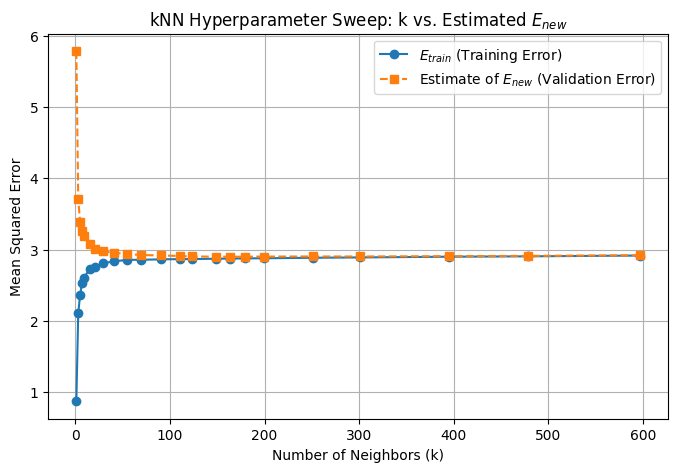

In [25]:
k_values = list(results.keys())
E_train_values = [results[k][0] for k in k_values]
E_new_values = [results[k][1] for k in k_values]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, E_train_values, marker='o', linestyle='-', label='$E_{\t{train}}$ (Training Error)')
plt.plot(k_values, E_new_values, marker='s', linestyle='--', label='Estimate of $E_{\t{new}}$ (Validation Error)')

# Labels and title
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Squared Error")
plt.title("kNN Hyperparameter Sweep: k vs. Estimated $E_{\t{new}}$")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Create the final Model
model_knn = KNeighborsRegressor(
    n_neighbors=best_k
)
X_train_holdout, y_train_holdout = train_holdout_df[X_columns], train_holdout_df[y_column]

# Fit it on the entire dataset (both train and holdout sets)
model_knn.fit(X_train_holdout, y_train_holdout)



KNeighborsRegressor(n_neighbors=163)

7. Use the Decision Trees algorithm to develop a model.
 • Choose two criterion loss functions for determining how to split regions. I will be using 'squared_error' and 'friedman_mse'

 • For each criterion loss function, perform a hyperparameter sweep to determine the best hyperparameter combination. Clearly state the hyperparameters and values that you swept over. For each
 hyperparameter combination you test, use the validation method you chose (k-fold / holdout) to
 estimate the value of E_new.

 • Create a plot containing the hyperparameters you swept over vs. their resulting estimated values
 of Enew for each criterion loss function you chose. Include the plot in your report.

 • For each criterion loss function, find the hyperparameter combination with the best performance.
 Train a final model on the full dataset using this value.

In [29]:
# Define a function to perform the hyperparameter sweep and plot results
def perform_sweep(criterion):
    best_score = np.inf
    best_params = None
    results = {}

    # Loop over all combinations of hyperparameters
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                # Initialize the model with the current hyperparameters
                model = DecisionTreeRegressor(
                    criterion=criterion,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=random_state,
                    max_features=None
                )

                # Train the model on the training set
                model.fit(X_train, y_train)

                # Make predictions on the holdout set
                y_pred = model.predict(X_holdout)

                # Calculate the MSE (E_new) on the holdout set
                mse_holdout = mean_squared_error(y_holdout, y_pred)
                mse_train = mean_squared_error(y_train, model.predict(X_train))
                results[(max_depth, min_samples_split, min_samples_leaf)] = (mse_train, mse_holdout)

                # Update the best score if current model is better
                if mse_holdout < best_score:
                    best_score = mse_holdout
                    best_params = {
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }

    return best_params, best_score, results

In [51]:
# Define the range of hyperparameters to test
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 50, 100, 200, 500, 1000, 2000],
    'min_samples_leaf': [1, 20, 50, 100, 250, 500]
}

In [44]:

# Perform hyperparameter sweep for squared error
print("Performing hyperparameter sweep for squared_error criterion...")
best_params_squared_error, best_score_squared_error, results_squared_error = perform_sweep('squared_error')

# Print the results
print(f"\nBest hyperparameters for squared_error: {best_params_squared_error}")
print(f"Best MSE (E_new) for squared_error: {best_score_squared_error}")



Performing hyperparameter sweep for squared_error criterion...

Best hyperparameters for squared_error: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best MSE (E_new) for squared_error: 2.8847724617140265


In [38]:

# Perform hyperparameter sweep for friedman mse
print("Performing hyperparameter sweep for friedman_mse criterion...")
best_params_friedman_mse, best_score_friedman_mse, results_friedman_mse = perform_sweep('friedman_mse')

# Print results
print(f"\nBest hyperparameters for friedman_mse: {best_params_friedman_mse}")
print(f"Best MSE (E_new) for friedman_mse: {best_score_friedman_mse}")

Performing hyperparameter sweep for friedman_mse criterion...

Best hyperparameters for friedman_mse: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best MSE (E_new) for friedman_mse: 2.8847724617140265


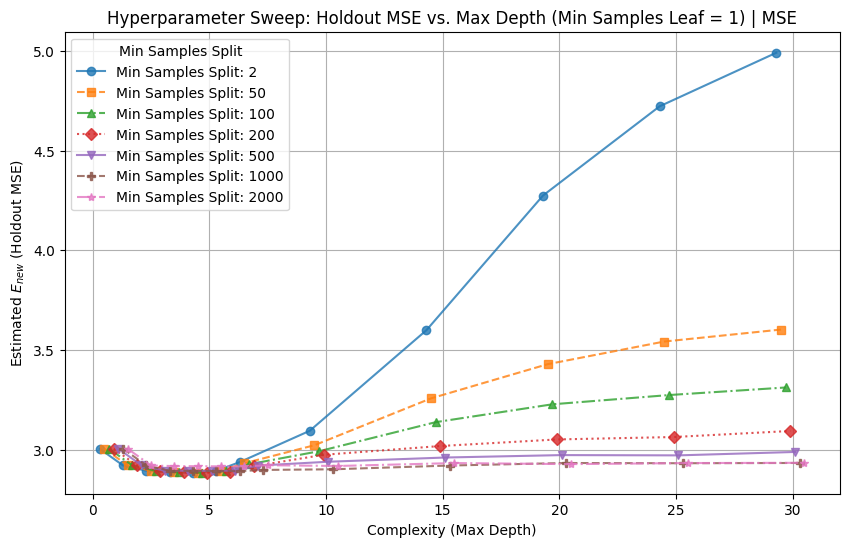

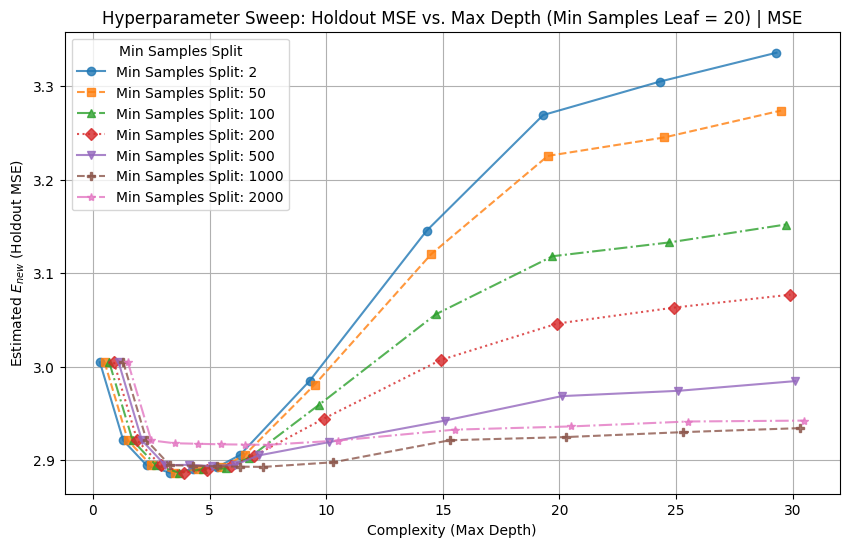

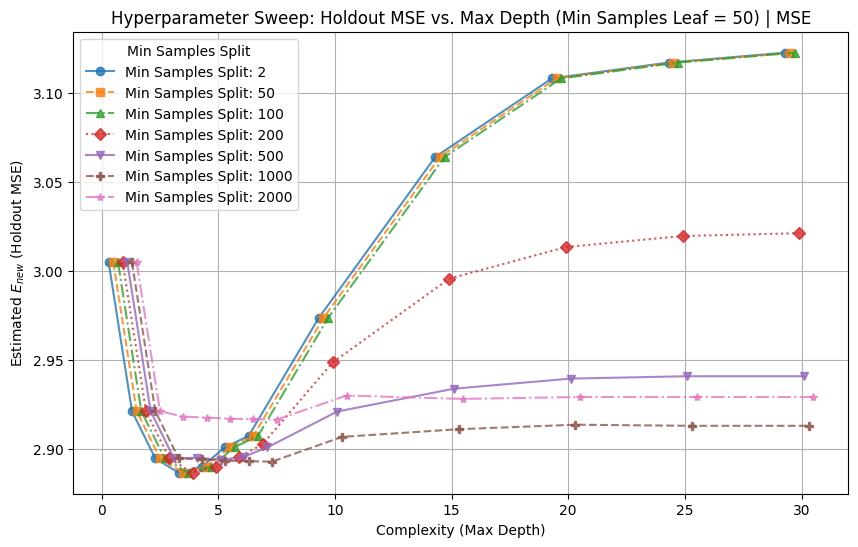

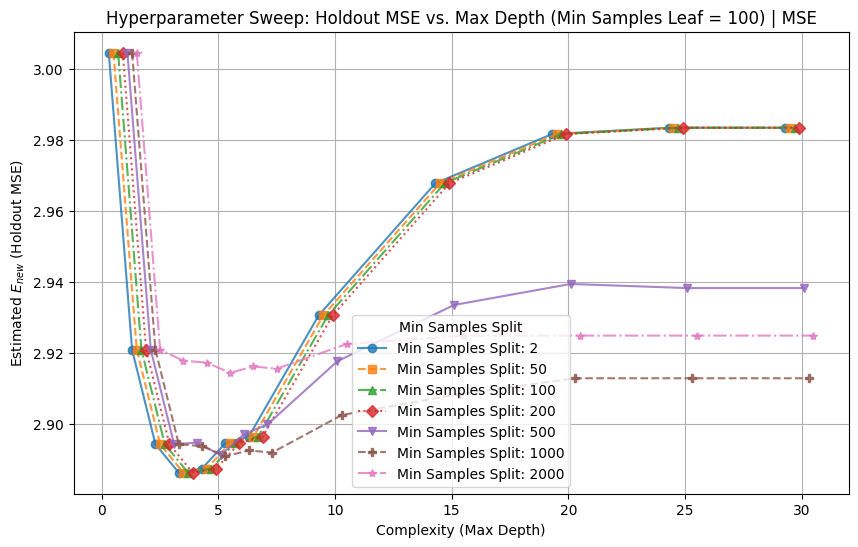

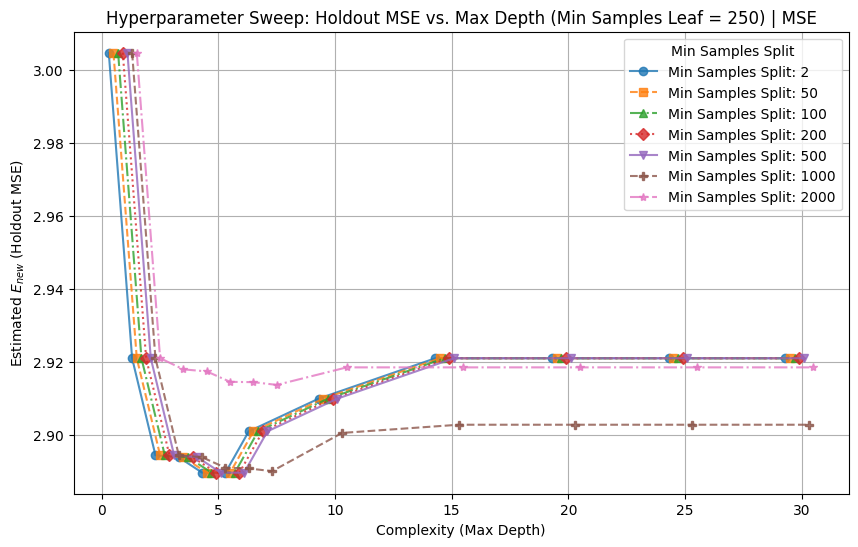

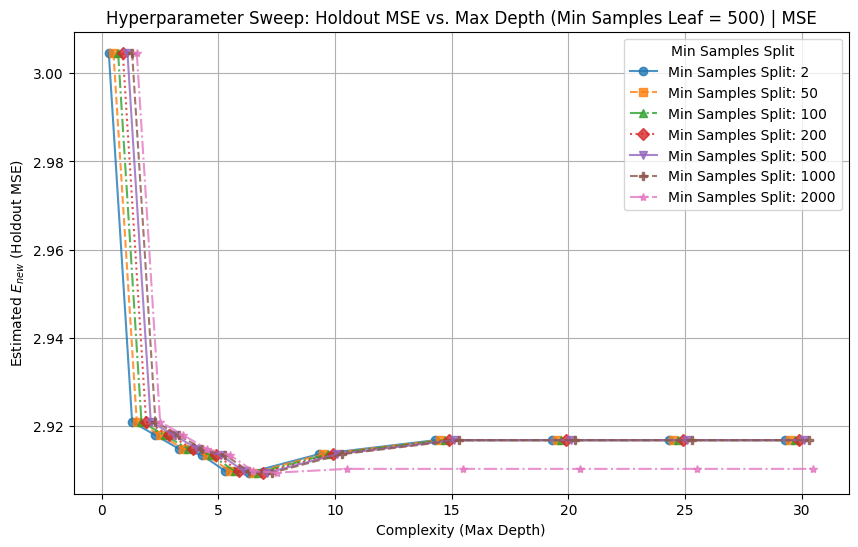

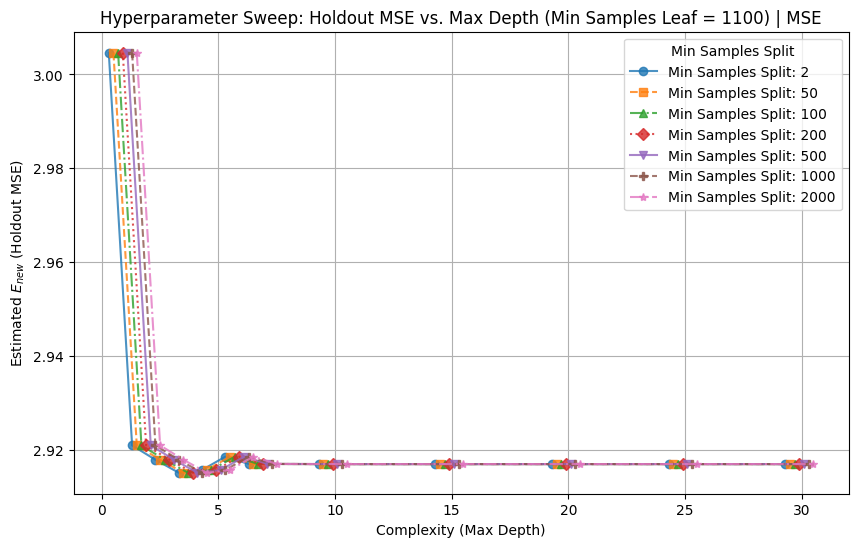

In [53]:
# Mean Squared Error
# Get unique min_samples_leaf values (sorted for consistency)
unique_min_samples_leaf = sorted({key[2] for key in results_squared_error.keys()})

# Get unique min_samples_split values (sorted for consistency)
unique_min_samples_split = sorted({key[1] for key in results_squared_error.keys()})

# Predefine markers and line styles for clarity.
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'P', '*']

# Create a colormap for consistency.
cmap = plt.get_cmap("tab10")
color_dict = {mss: cmap(i) for i, mss in enumerate(unique_min_samples_split)}

for msl in unique_min_samples_leaf:
    plt.figure(figsize=(10, 6))

    for i, mss in enumerate(unique_min_samples_split):
        x_vals = []
        y_vals = []
        for md in param_grid['max_depth']:
            key = (md, mss, msl)
            if key in results_squared_error:
                x_vals.append(md)
                y_vals.append(results_squared_error[key][1])

        if x_vals:
            # Adding a small jitter to x-values based on the index.
            jitter = 0.2 * (i - len(unique_min_samples_split) / 2)
            jittered_x_vals = [x + jitter for x in x_vals]

            plt.plot(jittered_x_vals, y_vals,
                     marker=markers[i % len(markers)],
                     linestyle=line_styles[i % len(line_styles)],
                     color=color_dict[mss],
                     alpha=0.8,
                     label=f"Min Samples Split: {mss}")

    plt.xlabel("Complexity (Max Depth)")
    plt.ylabel("Estimated $E_{\t{new}}$ (Holdout MSE)")
    plt.title(f"Hyperparameter Sweep: Holdout MSE vs. Max Depth (Min Samples Leaf = {msl}) | MSE")
    plt.legend(title="Min Samples Split")
    plt.grid(True)
    plt.show()

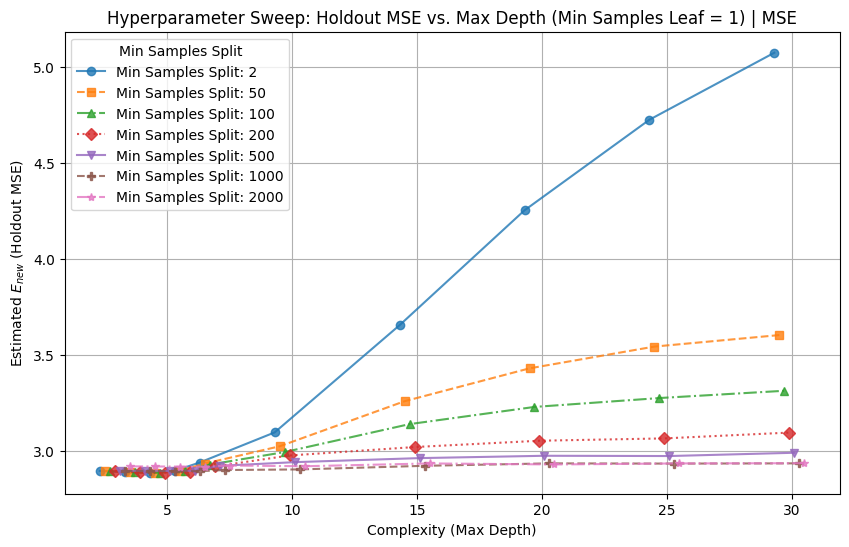

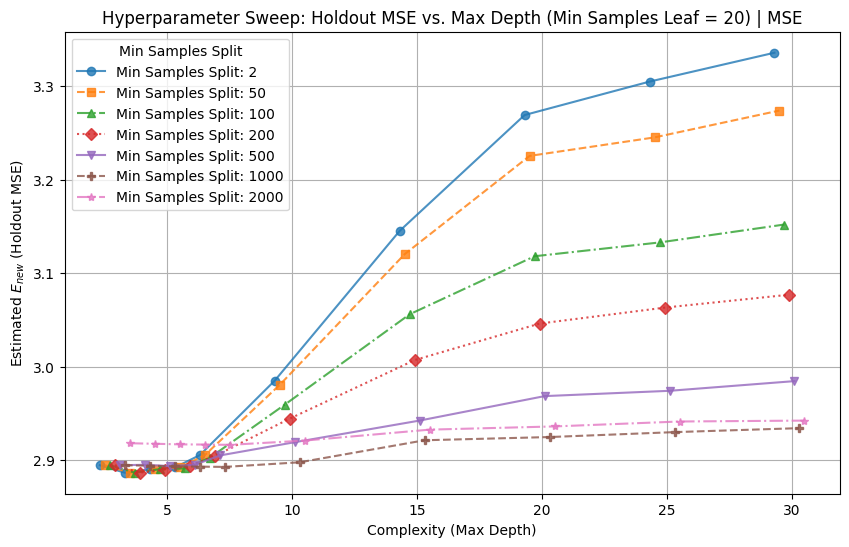

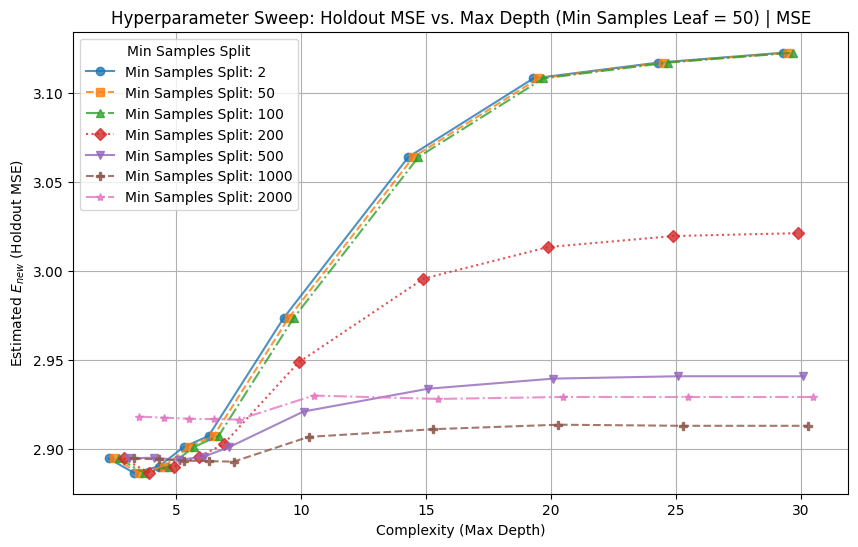

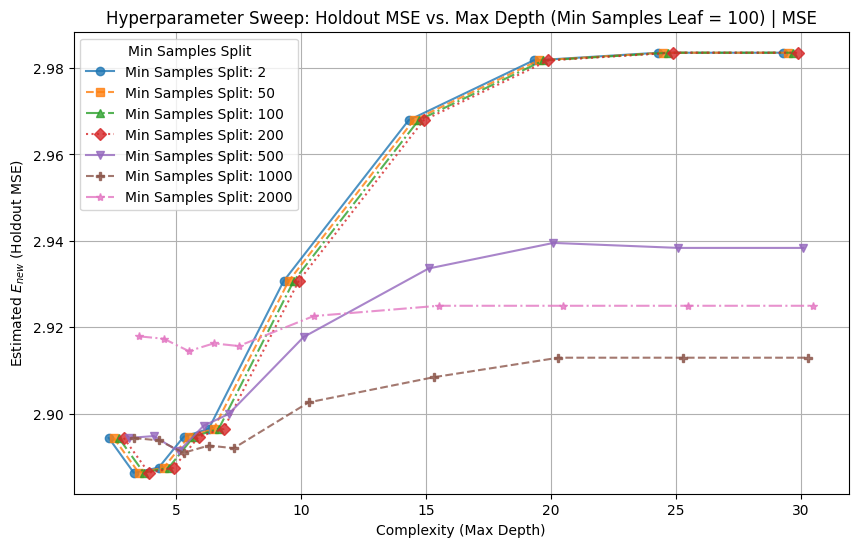

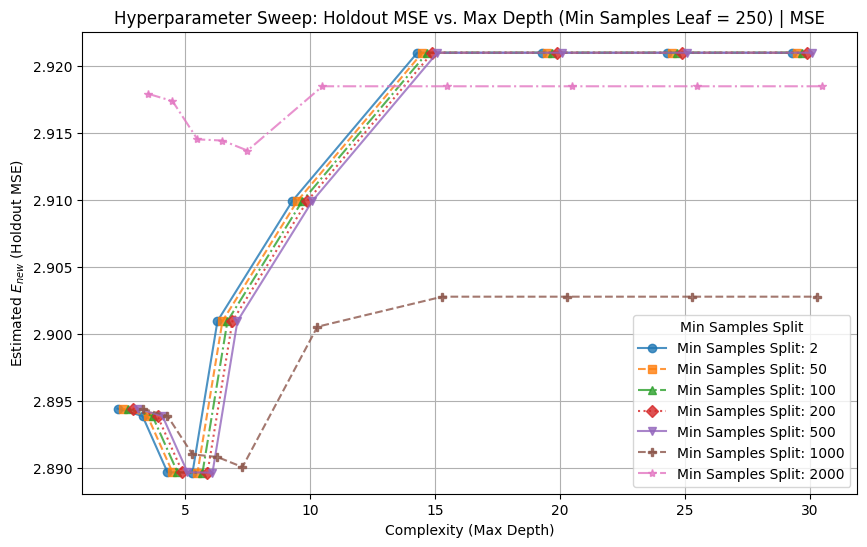

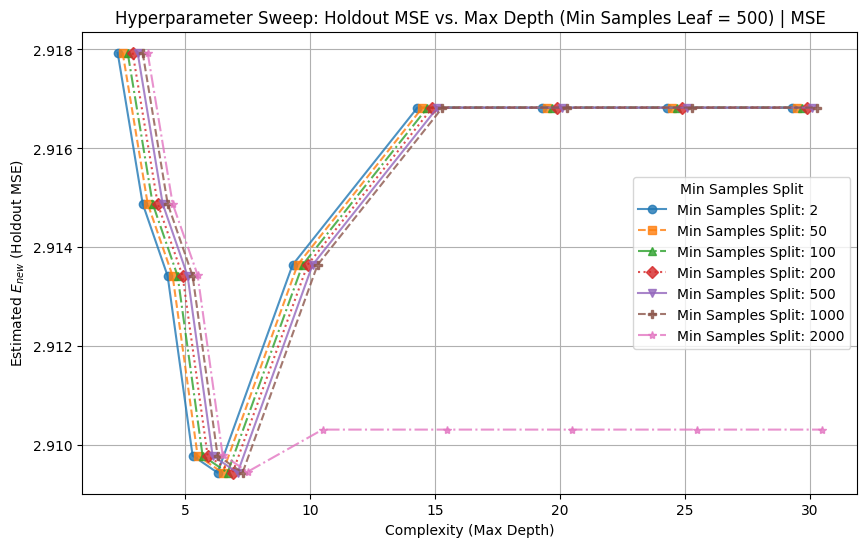

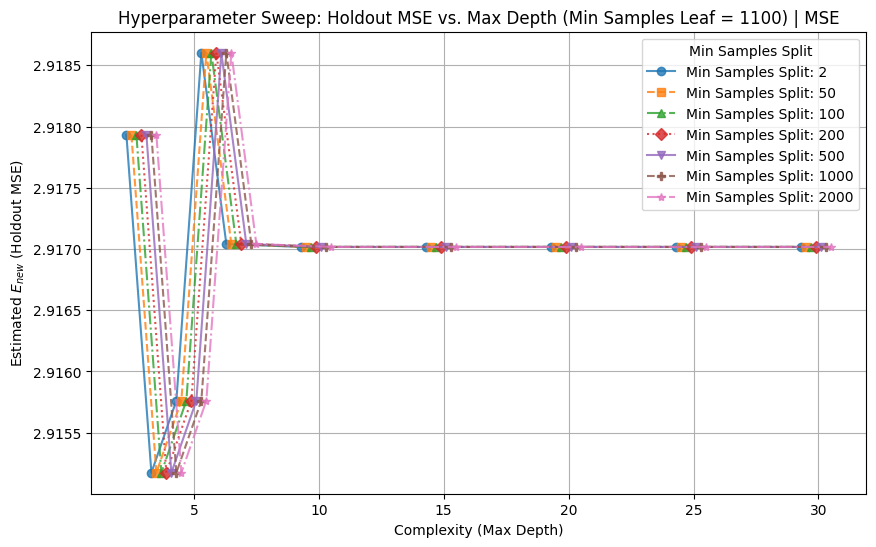

In [65]:
# Friedman MSE error

# Get unique min_samples_leaf values (sorted for consistency)
unique_min_samples_leaf = sorted({key[2] for key in results_friedman_mse.keys()})

# Get unique min_samples_split values (sorted for consistency)
unique_min_samples_split = sorted({key[1] for key in results_friedman_mse.keys()})

# Predefine markers and line styles for clarity.
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'P', '*']

# Create a colormap for consistency.
cmap = plt.get_cmap("tab10")
color_dict = {mss: cmap(i) for i, mss in enumerate(unique_min_samples_split)}

for msl in unique_min_samples_leaf:
    plt.figure(figsize=(10, 6))

    for i, mss in enumerate(unique_min_samples_split):
        x_vals = []
        y_vals = []
        for md in param_grid['max_depth']:
            key = (md, mss, msl)
            if key in results_friedman_mse:
                x_vals.append(md)
                y_vals.append(results_friedman_mse[key][1])

        if x_vals:
            # Adding a small jitter to x-values based on the index.
            jitter = 0.2 * (i - len(unique_min_samples_split) / 2)
            jittered_x_vals = [x + jitter for x in x_vals]

            plt.plot(jittered_x_vals, y_vals,
                     marker=markers[i % len(markers)],
                     linestyle=line_styles[i % len(line_styles)],
                     color=color_dict[mss],
                     alpha=0.8,
                     label=f"Min Samples Split: {mss}")

    plt.xlabel("Complexity (Max Depth)")
    plt.ylabel("Estimated $E_{\t{new}}$ (Holdout MSE)")
    plt.title(f"Hyperparameter Sweep: Holdout MSE vs. Max Depth (Min Samples Leaf = {msl}) | MSE")
    plt.legend(title="Min Samples Split")
    plt.grid(True)
    plt.show()

In [56]:
# Create the Final model (using the best crition and hyperpameters)
best_criterion = 'squared_error'

model_tree = DecisionTreeRegressor(
    max_depth=best_params_squared_error['max_depth'],
    min_samples_split=best_params_squared_error['min_samples_split'],
    min_samples_leaf=best_params_squared_error['min_samples_leaf'],
    criterion=best_criterion,
    random_state=random_state,
    max_features=None,
)

# Fit the model on the entire dataset (both train and holdout sets)
model_tree.fit(X_train_holdout, y_train_holdout)

DecisionTreeRegressor(max_depth=5, random_state=42)

8. Evaluate the performance of your final models (baseline, k-NN, Decision Tree) on the Test set you
 created earlier using the error function corresponding to your problem (see step 3). Make a plot
 comparing the errors of each model on the Test set.

In [58]:
# MSE of baseline
y_pred_baseline = model_baseline.predict(X_test)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
print(f"Baseline (Dummy Regressor) MSE: {mse_baseline}")

# MSE of kNN
y_pred_knn = model_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"KNN Regressor MSE: {mse_knn}")

# MSE of tree
y_pred_tree = model_tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree Regressor MSE: {mse_tree}")

Baseline (Dummy Regressor) MSE: 2.9045151739452257
KNN Regressor MSE: 2.7320775515752054
Decision Tree Regressor MSE: 2.7234975013132168


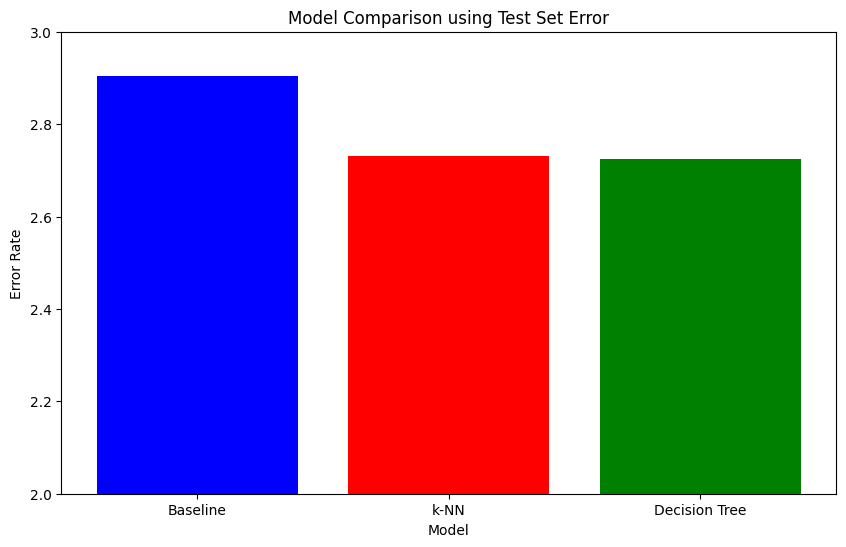

In [62]:
# Data for plotting
models = ['Baseline', 'k-NN', 'Decision Tree']
errors = [mse_baseline, mse_knn, mse_tree]
colors = ['blue', 'red', 'green']

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, errors, color=colors)
plt.xlabel('Model')
plt.ylabel('Error Rate')
plt.title('Model Comparison using Test Set Error')
plt.ylim([2, 3])
plt.show()